Library

In [1]:
import yfinance as yf
import numpy as np
from datetime import date, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.models import load_model

Import Data

In [ ]:
df = yf.download("AAPL", start = "2022-01-01", end = "2025-05-01")
print(date.today().strftime("%Y-%m-%d"))

data = df['Close'].values

print("Record:",len(data))
print(df.tail())

[*********************100%***********************]  1 of 1 completed

2025-05-01
Record: 834
Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2025-04-24  208.369995  208.830002  202.940002  204.889999  47311000
2025-04-25  209.279999  209.750000  206.199997  206.369995  38222300
2025-04-28  210.139999  211.500000  207.460007  210.000000  38743100
2025-04-29  211.210007  212.240005  208.369995  208.690002  36827600
2025-04-30  212.500000  213.580002  206.669998  209.300003  51661400


Plot Graph

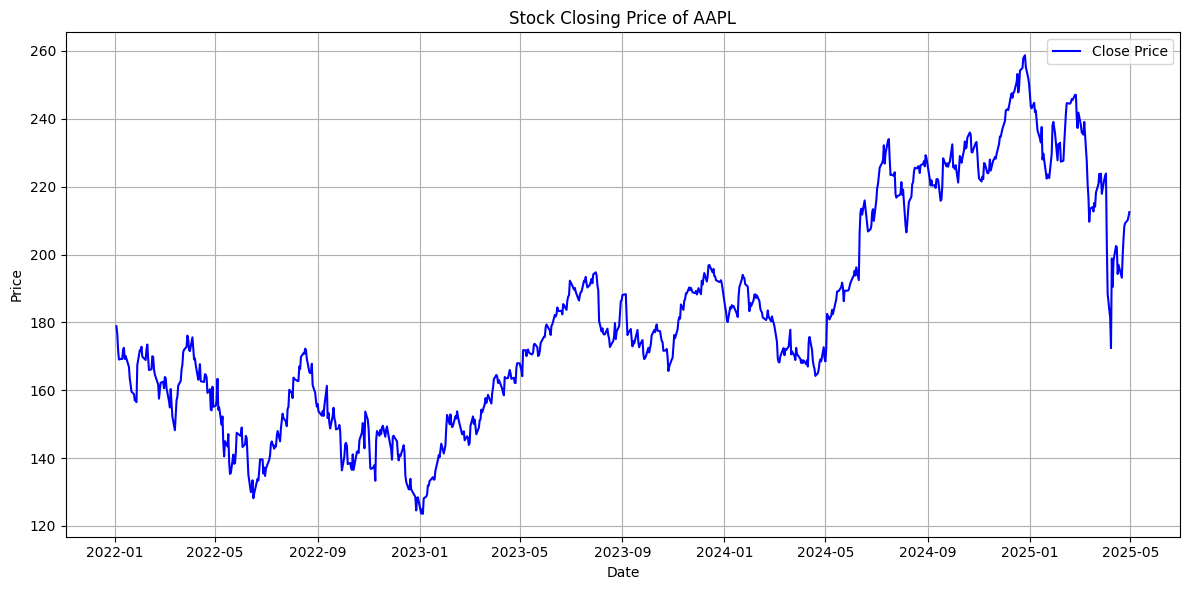

In [90]:
plt.figure(figsize = (12, 6))
plt.plot(df.index, data, label = 'Close Price', color = 'blue')
plt.title("Stock Closing Price of AAPL")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Scale Data Into [0,1] and 2D

In [107]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.reshape(-1, 1))

Split Data and Select Time Step

In [108]:
time_step = 60
train_size = int(len(scaled_data) * 0.8) 
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

X_train, y_train = [], []
X_test, y_test = [], []

for i in range(time_step, len(train_data)):
    X_train.append(train_data[i-time_step:i, 0])
    y_train.append(train_data[i, 0])

for i in range(time_step, len(test_data)):
    X_test.append(test_data[i-time_step:i, 0])
    y_test.append(test_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

Model LSTM

In [109]:
model = Sequential()
model.add(LSTM(units = 100, return_sequences = False, input_shape = (X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

c:\Users\BOSS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training Model

In [110]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_split = 0.2)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0286 - val_loss: 0.0233
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0043 - val_loss: 0.0027
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

Check Overfitting

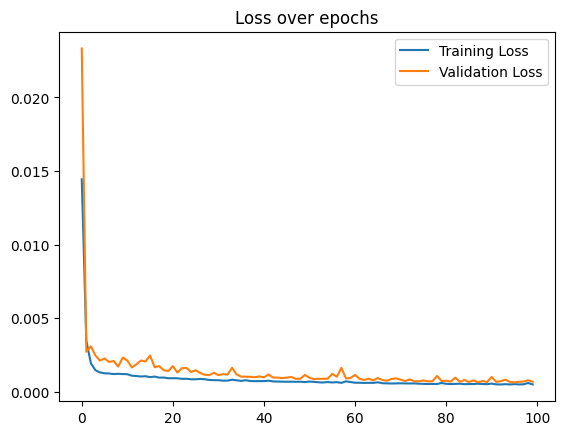

In [111]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [112]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = scaler.inverse_transform(train_pred)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1,1))
test_pred_inv = scaler.inverse_transform(test_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

rmse_train = np.sqrt(mean_squared_error(y_train_inv, train_pred_inv))
rmse_test = np.sqrt(mean_squared_error(y_test_inv, test_pred_inv))
print("Train RMSE:", rmse_train)
print("Test RMSE:", rmse_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Train RMSE: 3.067162927039066
Test RMSE: 5.478861494024529


Evalute Model

In [113]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [114]:
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, predictions)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)


Mean Squared Error (MSE): 30.017923270704692
Root Mean Squared Error (RMSE): 5.478861494024529
R² Score: 0.9088177371964489


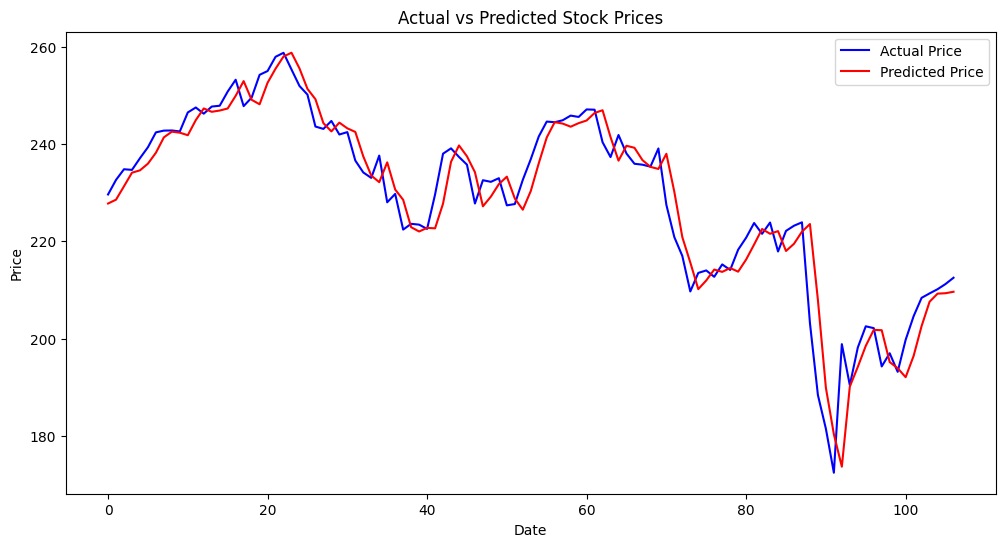

In [115]:
plt.figure(figsize = (12, 6))
plt.plot(y_test_actual, label = "Actual Price", color = 'blue')
plt.plot(predictions, label = "Predicted Price", color = 'red')
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

Save Model

In [116]:
model.save("AAPL_model1.h5")

In [6]:
model = load_model("AAPL_model1.h5")

Prediction

In [7]:
df = yf.download("AAPL", start = "2022-01-01", end = "2025-05-01")
data = df['Close'].values
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.reshape(-1, 1))

[*********************100%***********************]  1 of 1 completed


In [8]:
time_step = 60
dataf = yf.download("AAPL", period = "61d")
dataf = dataf[:-1]
last_60 = dataf['Close'].values[-time_step:]
last_60_scaled = scaler.transform(last_60.reshape(-1, 1))
X_input = last_60_scaled.reshape(1, time_step, 1)
print(len(last_60))
print(dataf.tail())

[*********************100%***********************]  1 of 1 completed

60
Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2025-04-25  209.279999  209.750000  206.199997  206.369995  38222300
2025-04-28  210.139999  211.500000  207.460007  210.000000  38743100
2025-04-29  211.210007  212.240005  208.369995  208.690002  36827600
2025-04-30  212.500000  213.580002  206.669998  209.300003  52286500
2025-05-01  213.320007  214.559998  208.899994  209.080002  56391200


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
Predicted next closing price: 212.05354


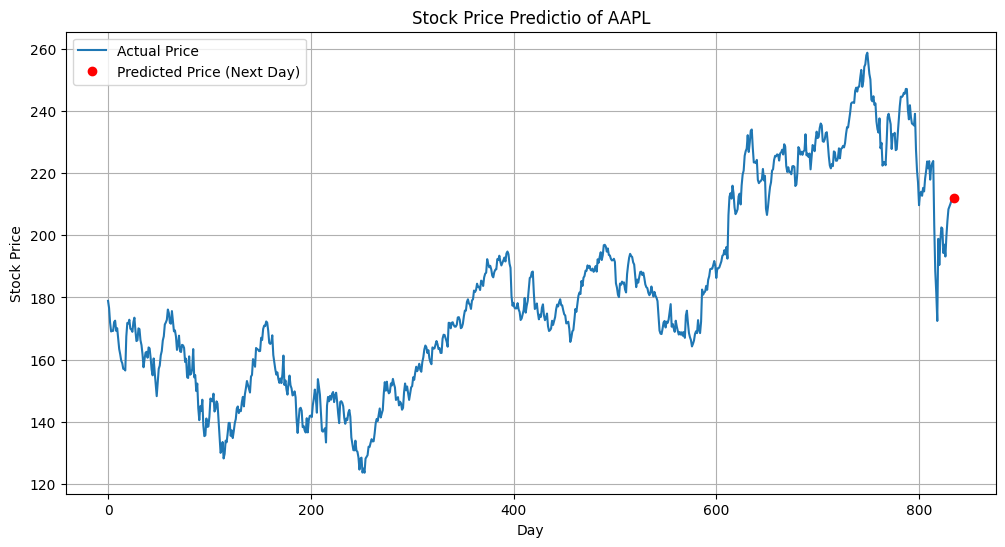

In [9]:
predicted_scaled = model.predict(X_input)
predicted_price = scaler.inverse_transform(predicted_scaled)

print(f"Predicted next closing price:", predicted_price[0][0])

actual_prices = scaler.inverse_transform(scaled_data)

days = [i for i in range(len(actual_prices))]
days_pred = [len(actual_prices)]

plt.figure(figsize = (12, 6))
plt.plot(days, actual_prices, label = 'Actual Price')
plt.plot(days_pred, [predicted_price[0][0]], 'ro', label = 'Predicted Price (Next Day)')
plt.legend()
plt.xlabel("Day")
plt.ylabel("Stock Price")
plt.title("Stock Price Predictio of AAPL")
plt.grid(True)
plt.show()